In [1]:
from google.colab import drive
import json
import matplotlib.pyplot as plt
drive.mount('/content/drive')
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Human Clustering of Points

In [2]:
clustering_data = '/content/drive/MyDrive/Clustering Data'

Function for storing the data point distribution as an image per subject per trial

In [3]:
def one_sub_one_trial(subject, filename):
 

  # color = ['blue', 'red', 'green', 'yellow', 'purple', 'brown']
  # col = 0
  for trial in range(len(subject)):
    fig = plt.figure(figsize=(1,5/8))
    plt.xlim((0,800))
    plt.ylim((0,500))
    plt.axis('off')

    clusters = subject[trial]['clusters']
    X = []
    Y = []
    for cluster in (clusters):
      for dot in cluster:
        X.append(dot['x'])
        Y.append(dot['y'])
       
    plt.scatter(X,Y, c ='black', s = 1/800)

    fig.savefig('/content/drive/MyDrive/small_cluster_image/'+str(filename)+'_trial_'+str(trial)+'.png')
    plt.close()
 


Load the datapoints and then export them as images (Already in the github)

In [4]:
# import os

# subject = 0
# for filename in os.listdir(clustering_data):
#     if filename.endswith('.json'):
#         with open(os.path.join(clustering_data, filename)) as f:
#             subject = json.load(f)
            
#             one_sub_one_trial(subject, filename[:-5])
          
            

Human clustering points in images

In [5]:
clustering_image = '/content/drive/MyDrive/small_cluster_image/'

In [6]:
from PIL import Image
import os
import numpy as np

In [7]:
dataset = list(filter(lambda x: '.png' in x, os.listdir(clustering_image)))

In [39]:
data = np.array([np.array(Image.open(clustering_image + fname).convert('L')) for fname in dataset])
print('number of images: ', len(data))

number of images:  5264


Divide the dataset into training and testing images

In [40]:
n = len(data)
x_test = data[5 * n//6:]
x_train = data[:n//6 * 5]
print('x_test shape: ', x_test.shape)
print('x_train shape: ', x_train.shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 45,72, 1))
x_test = np.reshape(x_test, (len(x_test), 45, 72, 1))


x_test shape:  (878, 45, 72)
x_train shape:  (4385, 45, 72)


In [41]:
print(x_test.shape)

(878, 45, 72, 1)


Show some original images

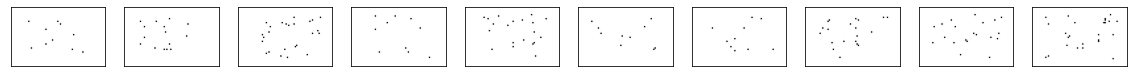

In [42]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Digit
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(data[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [43]:
import keras
from keras import layers
from keras.callbacks import EarlyStopping

Build an autoencoder for compressing images

In [44]:
input_img = keras.Input(shape=(45, 72, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((3, 3), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((3, 3), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((3, 3))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((3, 3))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
encoder = keras.Model(input_img, encoded)
autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Show the architecture of the autoencoder

In [45]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 45, 72, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 72, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 24, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 8, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 8, 16)          2320      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 15, 24, 16)        0   

In [46]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="auto", restore_best_weights=True)])

Epoch 1/200
138/138 [==============================] - 21s 152ms/step - loss: 0.1826 - val_loss: 0.0078
Epoch 2/200
138/138 [==============================] - 21s 151ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 3/200
138/138 [==============================] - 21s 151ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 4/200
138/138 [==============================] - 21s 152ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 5/200
138/138 [==============================] - 21s 152ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 6/200
138/138 [==============================] - 21s 153ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 7/200
138/138 [==============================] - 21s 153ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 8/200
138/138 [==============================] - 21s 153ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 9/200
138/138 [==============================] - 21s 154ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/200
138/138 [==============================] - 21s 154m

In [47]:
compressed_img = encoder.predict(x_test)
results = autoencoder.predict(x_test)

Show images comparing original, reconstructed and compressed images

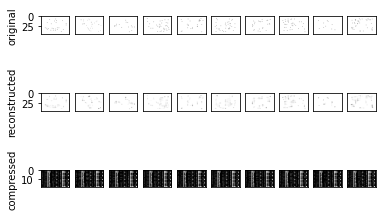

In [48]:
n = 10
plt.figure()
for i, k in enumerate(np.random.randint(1,len(results)+1,n)):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[k].reshape(45, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('original')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(results[k].reshape(45, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('reconstructed')

    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(compressed_img[k].reshape(20, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('compressed')
plt.show()

In [49]:
import tensorflow as tf
print("original vs reconstructed", np.mean(tf.image.ssim(x_test, results, max_val = np.max(results))))

original vs reconstructed 0.9340564
